# Poisson disc sampling

Quality meshes are important for producing reliable solution in surface process modelling. For any given node in an unstructured mesh, its neighbours should be spaced more or less at an equal radius. For this we turn to Poisson disc sampling using an efficient $O(N)$ [algorithm](http://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf).

The premise of this algorithm is to ensure that points are tightly packed together, but no closer than a specified minimum distance. This distance can be uniform across the entire domain, or alternatively a 2D numpy array of radius lengths can be used to bunch and relax the spacing of nodes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

## Uniform spacing

### Landscape

In this example we create higher resolution where the slope is steeper.

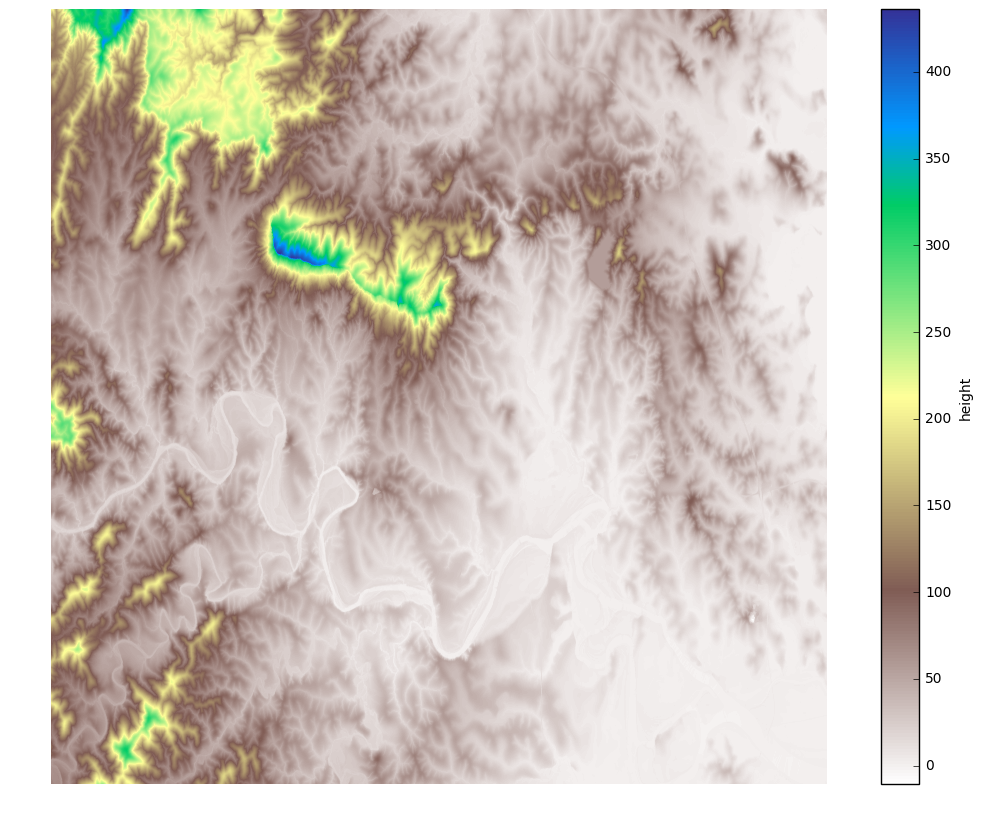

In [2]:
dem = imread('data/port_macquarie.tif', mode='F')

rows, columns = dem.shape
aspect_ratio = float(columns) / float(rows)

spacing = 5.0

minX, maxX = 0.0, spacing*dem.shape[1]
minY, maxY = 0.0, spacing*dem.shape[0]


fig = plt.figure(1, figsize=(10*aspect_ratio,10))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow(dem, cmap='terrain_r', origin='lower', aspect=aspect_ratio)
fig.colorbar(im, ax=ax, label='height')

In [3]:
gradX, gradY = np.gradient(dem, 5., 5.) # 5m resolution in each direction
slope = np.hypot(gradX, gradY)

print("min/max slope {}".format((slope.min(), slope.max())))

min/max slope (0.0, 5.0558634)


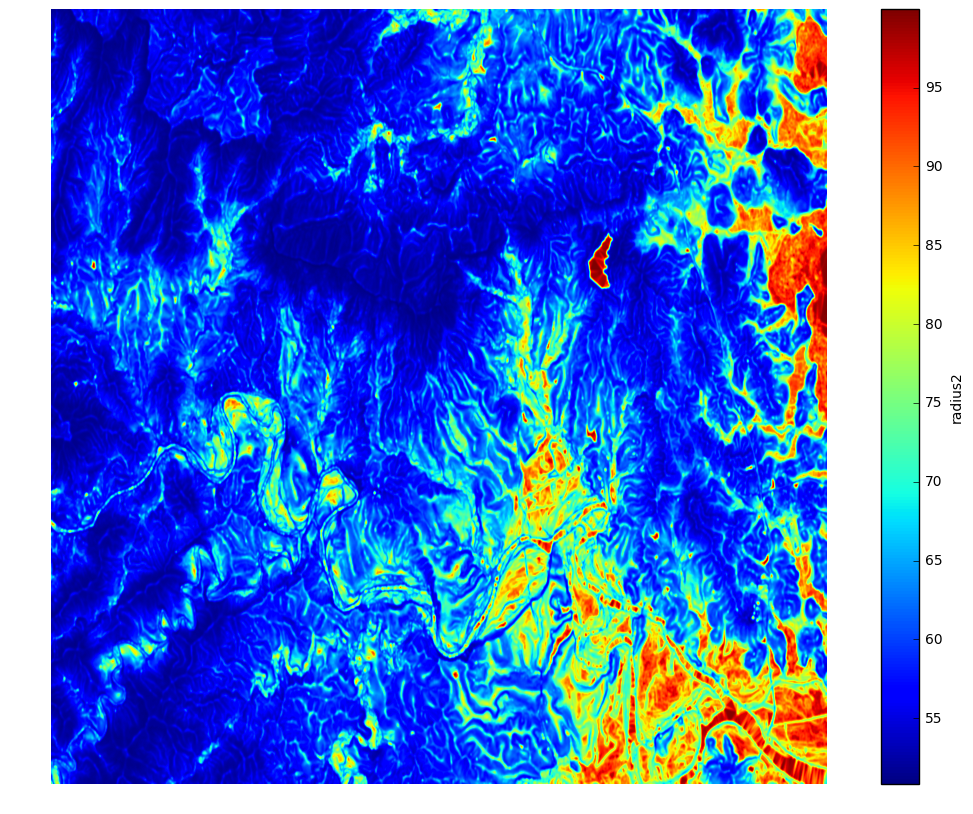

In [4]:
height, width = slope.shape

radius_min = 50.0
radius_max = 100.0

radius = 1.0/(slope + 0.02)
radius = (radius - radius.min()) / (radius.max() - radius.min()) 
radius = radius * (radius_max-radius_min) + radius_min

# apply gaussian filter for better results
from scipy.ndimage import gaussian_filter
radius2 = gaussian_filter(radius, 5.)

# radius -= slope.min()
# radius /= slope.max()/100
# radius += 1e-8

fig = plt.figure(1, figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow((radius2), cmap='jet', origin='lower', aspect=aspect_ratio)
fig.colorbar(im, ax=ax, label='radius2')

plt.show()

In [5]:
x, y, bmask = meshtools.poisson_square_mesh(minX, maxX, minY, maxY, spacing*2.0, boundary_samples=500, r_grid=radius2*2.0)
print("{} samples".format(x.size))

20544 samples


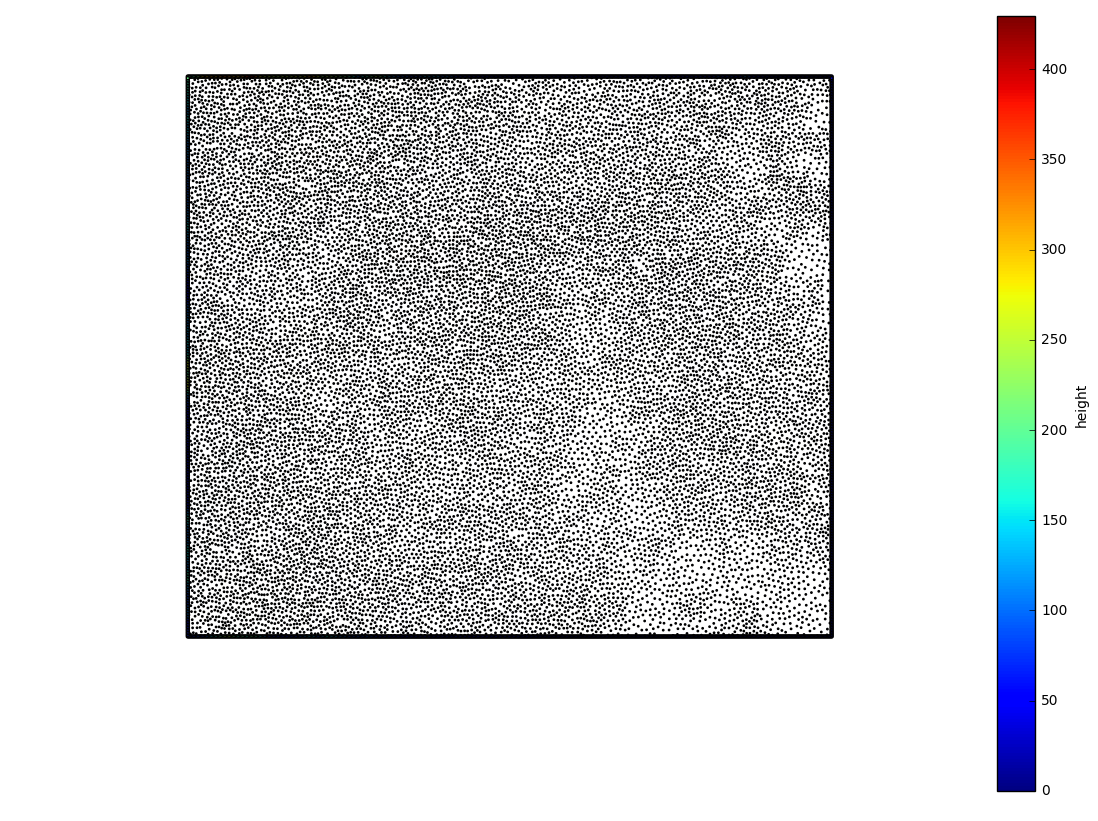

In [6]:
from scipy import ndimage

coords = np.stack((y, x)).T / spacing
meshheights = ndimage.map_coordinates(dem, coords.T, order=3, mode='nearest')


fig = plt.figure(1, figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)
ax.axis('off')
sc = ax.scatter(x[bmask], y[bmask], s=1, c=meshheights[bmask])
sc = ax.scatter(x[~bmask], y[~bmask], s=5, c=meshheights[~bmask])

fig.colorbar(sc, ax=ax, label='height')
plt.show()

## TriMesh

Now the points can be triangulated to become a quality unstructured mesh.

Triangulation reorders x,y points - be careful!

In [7]:
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh

dm = meshtools.create_DMPlex_from_points(x, y, bmask, refinement_steps=2)
mesh = SurfaceProcessMesh(dm)

# Triangulation reorders points
coords = np.stack((mesh.tri.points[:,1], mesh.tri.points[:,0])).T / spacing
meshheights = ndimage.map_coordinates(dem, coords.T, order=3, mode='nearest')

mesh.update_height(meshheights)

0 - Delaunay triangulation 0.584733s
0 - Calculate node weights and area 0.013416s
0 - Find boundaries 0.000872999999999s
0 - cKDTree 0.044705s
0 - Construct neighbour cloud array 1.122294s
0 - Construct rbf weights 0.360352s
0 - Compute slopes 1.08006s
0 - Build downhill matrices 0.36064s


Landscape analysis statistics

In [8]:
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.01)[0]
low_points = mesh.identify_low_points()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(mesh.down_neighbour[1] == nodes)[0]

# print statistics
print("mean gradient {}\nnumber of flat spots {}\nnumber of low points {}".format(gradient_mean,
                                                                                  flat_spots.size,
                                                                                  low_points.shape[0]))

mean gradient 0.143973469734
number of flat spots 2834
number of low points 1555


In [9]:
print low_points

[    42    755    759 ..., 317829 317889 317940]


In [10]:
flowpaths1 = mesh.cumulative_flow(mesh.area)

DHmat**2
DHmat**2 - done 


In [11]:
filled_height = np.zeros_like(mesh.height)
filled_height[low_points] = ( mesh.height[mesh.neighbour_cloud[low_points,1:7]].mean(axis=1) ) 
raw_heights = mesh.height.copy()



In [29]:
new_heights = mesh.backfill_low_points(50)

50  Low points =  212
 - Partial rebuild of downhill matrices 0.125079s
49  Low points =  212
 - Partial rebuild of downhill matrices 0.114674s
48  Low points =  211
 - Partial rebuild of downhill matrices 0.101395s
47  Low points =  208
 - Partial rebuild of downhill matrices 0.101354s
46  Low points =  207
 - Partial rebuild of downhill matrices 0.10022s
45  Low points =  207
 - Partial rebuild of downhill matrices 0.101841s
44  Low points =  206
 - Partial rebuild of downhill matrices 0.100593s
43  Low points =  205
 - Partial rebuild of downhill matrices 0.100151s
42  Low points =  205
 - Partial rebuild of downhill matrices 0.100122s
41  Low points =  204
 - Partial rebuild of downhill matrices 0.10068s
40  Low points =  203
 - Partial rebuild of downhill matrices 0.10145s
39  Low points =  203
 - Partial rebuild of downhill matrices 0.101931s
38  Low points =  202
 - Partial rebuild of downhill matrices 0.114484s
37  Low points =  202
 - Partial rebuild of downhill matrices 0.120

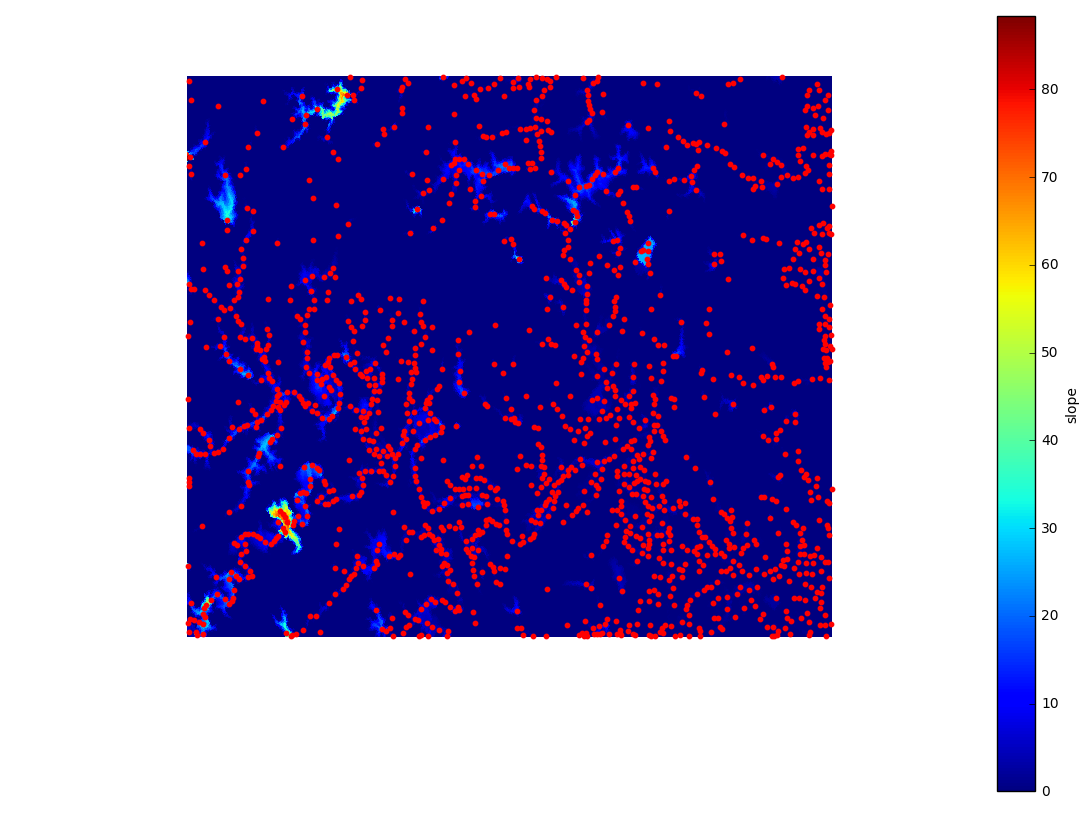

In [30]:
fig = plt.figure(1, figsize=(10*aspect_ratio,10))
ax = fig.add_subplot(111)
ax.axis('off')
im1 = ax.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, new_heights-raw_heights, linewidth=0.1, cmap='jet')
fig.colorbar(im1, ax=ax, label='slope')
ax.scatter(mesh.tri.x[low_points], mesh.tri.y[low_points], s=10.0, color="Red")
plt.show()

In [31]:
low_points2 = mesh.identify_low_points()


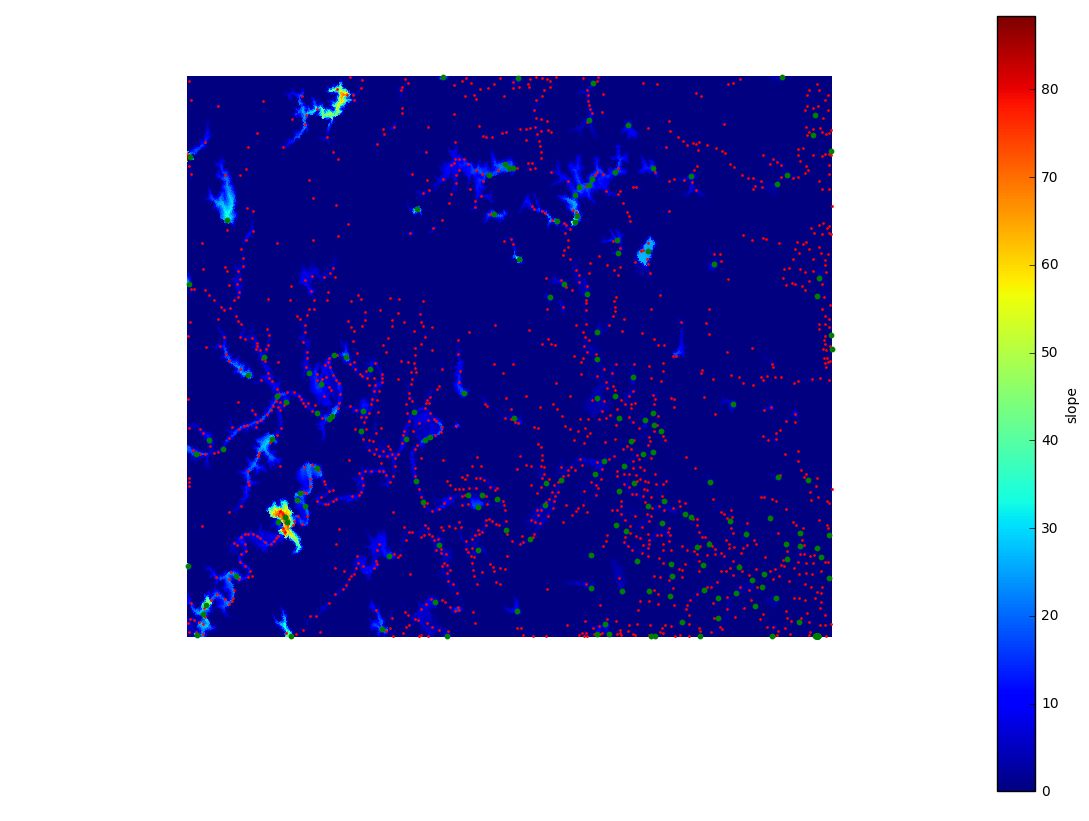

In [32]:
fig = plt.figure(1, figsize=(10*aspect_ratio,10))
ax = fig.add_subplot(111)
ax.axis('off')
im1 = ax.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, new_heights-raw_heights, linewidth=0.1, cmap='jet')
fig.colorbar(im1, ax=ax, label='slope')
ax.scatter(mesh.tri.x[low_points], mesh.tri.y[low_points], s=1.0, color="Red")
ax.scatter(mesh.tri.x[low_points2], mesh.tri.y[low_points2], s=10.0, color="Green")

plt.show()

In [33]:
its, flowpaths2 = mesh.cumulative_flow_verbose(mesh.area, maximum_its=1000, verbose=True)


DHmat**2
DHmat**2 - done 
0: Max Delta - 16626.1395046 
10: Max Delta - 14015.17359 
20: Max Delta - 10471.521829 
30: Max Delta - 14397.0096064 
40: Max Delta - 14793.2205496 
50: Max Delta - 10025.2362204 
60: Max Delta - 9562.18086263 
70: Max Delta - 11167.1777426 
80: Max Delta - 9524.4127844 
90: Max Delta - 12096.7026285 
100: Max Delta - 9421.50787659 
110: Max Delta - 12782.001492 
120: Max Delta - 11971.6947936 
130: Max Delta - 9463.63426984 
140: Max Delta - 8579.33545326 
150: Max Delta - 8497.83740048 
160: Max Delta - 6660.0968869 
170: Max Delta - 8943.59938176 
180: Max Delta - 4662.97924 
190: Max Delta - 4347.51914411 
200: Max Delta - 4346.92042761 
210: Max Delta - 4532.60005721 
220: Max Delta - 4325.02091189 
230: Max Delta - 2030.23705809 
240: Max Delta - 299.575743394 
250: Max Delta - 15.0545375404 
260: Max Delta - 6.94321652929 
270: Max Delta - 0.639028841329 
280: Max Delta - 0.00329148816605 


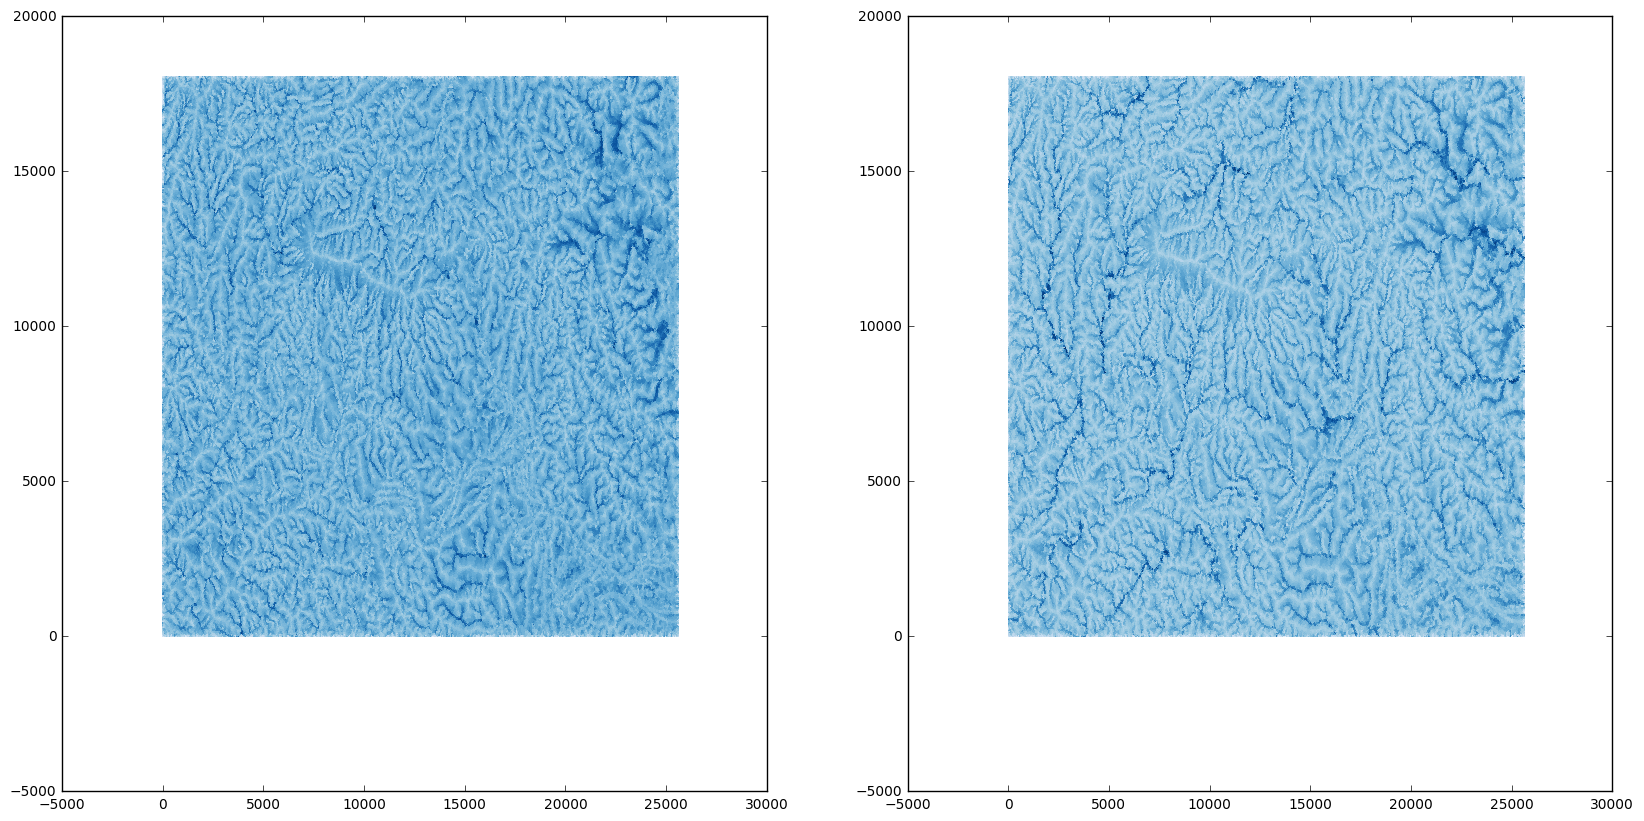

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    
im1 = ax1.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, np.log(np.sqrt(flowpaths1)) , cmap='Blues')
im2 = ax2.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, np.log(np.sqrt(flowpaths2)) , cmap='Blues')

# fig.colorbar(im1, ax=ax1)
plt.show()